<a href="https://colab.research.google.com/github/DajeanArcila/biblioteca_pandas/blob/main/dados_sasonais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

proposito: colectar datos historicos de una empresa de energia para despues encontrarle la estacionalidad y asi predecir el proximo consumo o los proximos datos


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from statsmodels.tsa.arima.model import ARIMA

In [ ]:
!pip install spicy

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.9 MB/s eta 0:00:00


In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
from xgboost import XGBRegressor

In [ ]:
df= pd.read_excel('/content/energy.xlsx', index_col='DATE', parse_dates=True)
df.head()

energy
DATE               
1985-01-01  71.5920
1985-02-01  69.7870
1985-03-01  61.6790
1985-04-01  56.7479
1985-05-01  54.6165

In [ ]:
df.shape

(408, 1)

In [ ]:
df.describe()

energy
count  408.000000
mean    88.062232
std     15.168540
min     54.616500
25%     76.499750
50%     88.940450
75%     99.733200
max    126.362600

In [ ]:
df.index.min(), df.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2018-12-01 00:00:00'))

In [ ]:
df.columns= {'produccion'}

<Axes: xlabel='DATE'>

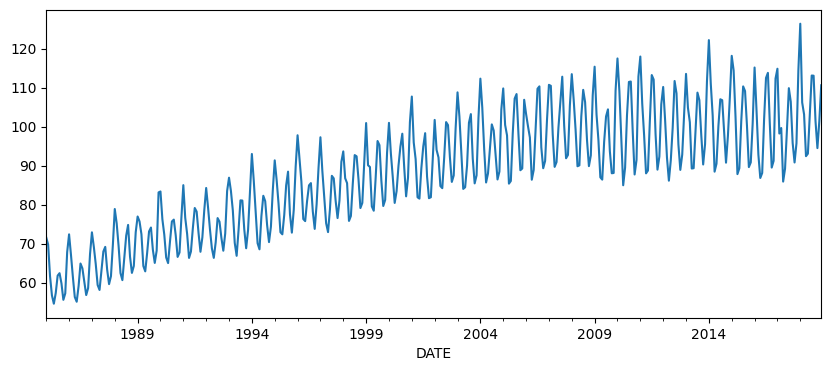

In [ ]:
df.produccion.plot(figsize=(10,4))

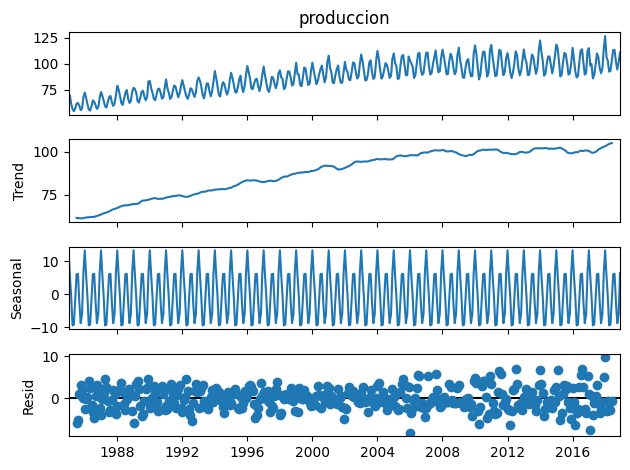

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

resultado= seasonal_decompose(df.produccion)
fig= resultado.plot()

In [ ]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(df['produccion'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.252399047046594
p-value: 0.18777984601967806


en esta parte analizamos el p value para ver si el valor es mayor a 5% para saber si ella es estacional


In [ ]:
df.head()

produccion
DATE                  
1985-01-01     71.5920
1985-02-01     69.7870
1985-03-01     61.6790
1985-04-01     56.7479
1985-05-01     54.6165

In [ ]:
df.diff().head()
#la funcion diff toma el valor del dia actual y lo substrae del anterior dia y asi se obtiene los valores abajo

produccion
DATE                  
1985-01-01         NaN
1985-02-01     -1.8050
1985-03-01     -8.1080
1985-04-01     -4.9311
1985-05-01     -2.1314

aqui despues de colocar la funcion diff, ella analisa los valores de un dia para el otro y a partir de un valor vemos si hay una estacionalidad en ese periodo

In [ ]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(df['produccion'].diff().dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -7.450892277526341
p-value: 5.67456995585561e-11


In [ ]:
fit_arima= auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3, m=12, seasonal=True,
                      M=6,
                      D=1,
                      Start_p=1,
                      Star_q=1,
                      max_P=2,
                      max_Q=2,
                      information_criterion='aic',
                      trace=True,
                      error_action='ignore',
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1836.822, Time=3.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2065.666, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1995.499, Time=0.46 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1885.373, Time=0.91 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1836.394, Time=1.74 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1835.595, Time=5.02 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1833.415, Time=5.02 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=1815.469, Time=5.19 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=1821.459, Time=2.55 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1854.836, Time=5.74 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=1882.884, Time=3.67 sec
 ARIMA(2,1,1)(2,1,2)[12]             : AIC=1817.380, Time=9.91 sec
 ARIMA(1,1,2)(2,1,2)[12]             : AIC=1817.329, Time=5.62 sec
 ARIMA(0,1,0)(2,1,2)[12]

In [ ]:
#encima vemos los mejores resultados p q y d (que seria 1 1 1) y lo usamos abajo
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(df, order=(1,1,1), seasonal_order=(1,1,2,6))
resultado_sarimax = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                             produccion   No. Observations:                  408
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 6)   Log Likelihood                -927.200
Date:                                Sat, 18 May 2024   AIC                           1866.400
Time:                                        21:46:24   BIC                           1890.364
Sample:                                    01-01-1985   HQIC                          1875.889
                                         - 12-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5125      0.042     12.156      0.000       0.430       0.595
ma.L1         -0.9601      0.017    -56.250      0.000      -0.994      -0.927
ar.S.L6       -0.9973      0.003   -350.055      0.000      -1.003      -0.992
ma.S.L6        0.1026      0.037      2.775      0.006       0.030       0.175
ma.S.L12      -0.7748      0.035    -22.180      0.000      -0.843      -0.706
sigma2         5.6413      0.322     17.544      0.000       5.011       6.272
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                29.17
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
predicciones= resultado_sarimax.get_prediction(start=-12)
prediccion_media= predicciones.predicted_mean


In [ ]:
intervalo_confianza= predicciones.conf_int()
limite_abajo= intervalo_confianza.iloc[:,0]
limite_arriba= intervalo_confianza.iloc[:,1]

limite_abajo[0], limite_arriba[0]


(115.1447404570401, 124.45517675290846)

In [ ]:
prediccion_media[0]

119.79995860497428

In [ ]:
fechas_pronostico=np.asarray(prediccion_media.index)
datas =np.asarray(df.index)

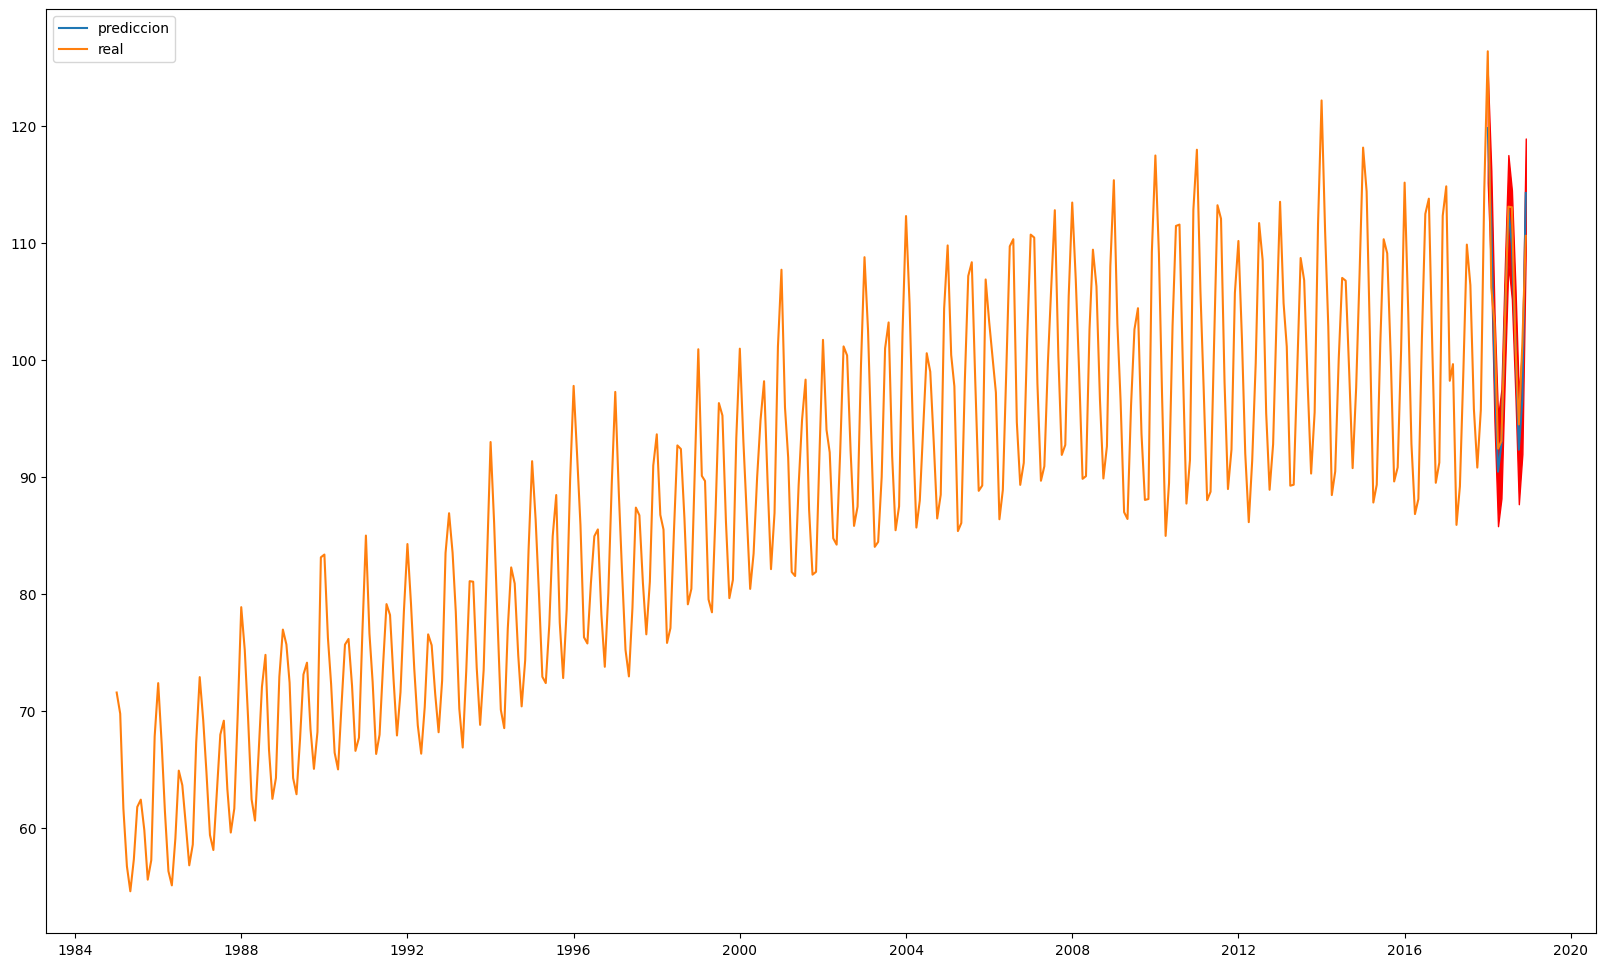

In [ ]:
plt.figure(figsize=(20,12))
plt.plot(fechas_pronostico,prediccion_media,label='prediccion')
plt.fill_between(fechas_pronostico,limite_abajo,limite_arriba,color= 'red')
plt.plot(datas,df.values,label='real')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

mae= mean_absolute_error(df[-12:].values,prediccion_media.values)

print(mae)

2.7071201498891306


In [ ]:
forecast= resultado_sarimax.get_forecast(steps=12)
forecast_medio=forecast.predicted_mean
forecast_medio.size

12

In [ ]:
intervalo_confianza_forecast= forecast.conf_int()
intervalo_abajo_f= intervalo_confianza_forecast.iloc[:,0]
intervalo_arriba_f= intervalo_confianza_forecast.iloc[:,1]

intervalo_abajo_f[10], intervalo_arriba_f[10]

(91.38813005236821, 103.10930985132882)

In [ ]:
forecast_medio[10]

97.24871995184851

In [ ]:
fechas_forecast=  np.asarray(forecast_medio.index)
pred_dates= np.asarray(prediccion_media.index)

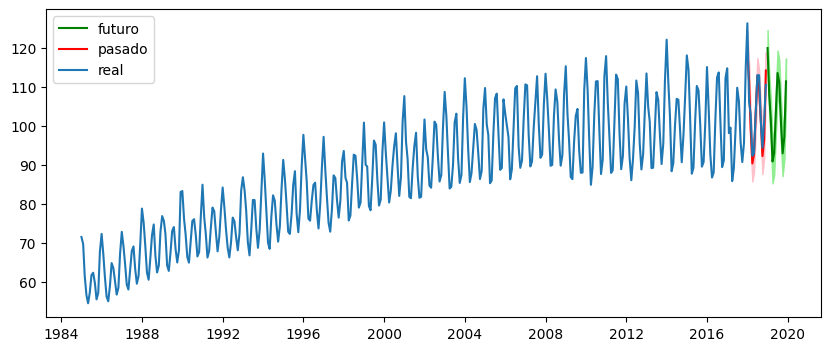

In [ ]:
dates= np.asarray(df.index)
plt.figure(figsize=(10,4))
plt.plot(fechas_forecast,forecast_medio.values, color='green', label='futuro')
plt.fill_between(fechas_forecast,intervalo_abajo_f,intervalo_arriba_f,color= 'lightgreen')


plt.plot(fechas_pronostico,prediccion_media.values,color='red',label='pasado')
plt.fill_between(fechas_pronostico,limite_abajo,limite_arriba,color= 'pink')

plt.plot(dates,df.values,label='real')
plt.legend(loc='upper left')
plt.show()

asi mostramos que pudimos analizar estos datos de energia y encontrarle la estacionalidad para asi establecerla, entrenar nuestro modelo y despues a partir de una medida de datos pasados que tomemos, podemos predecir los datos futuros adaptandose nuestro promedio al 95%